In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
IMG_SIZE = 224


 Loading the Data

In [1]:
def parse_label_file(label_path):
    label_path = label_path.decode("utf-8")
    with open(label_path, 'r') as f:
        line = f.readline().strip()
        class_id, cx, cy, w, h = map(float, line.split())
        x1 = (cx - w / 2) * IMG_SIZE
        y1 = (cy - h / 2) * IMG_SIZE
        x2 = (cx + w / 2) * IMG_SIZE
        y2 = (cy + h / 2) * IMG_SIZE
        return np.array([x1, y1, x2, y2, class_id], dtype=np.float32)
def load_image_and_label(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.numpy_function(parse_label_file, [label_path], tf.float32)
    label.set_shape([5])
    return image, label
def create_dataset(image_dir, label_dir):
    image_paths, label_paths, test_images = [], [], []

    for fname in os.listdir(image_dir):
        if fname.endswith('.jpg'):
            img_path = os.path.join(image_dir, fname)
            lbl_path = os.path.join(label_dir, fname.replace(".jpg", ".txt"))

            if os.path.exists(lbl_path):
                image_paths.append(img_path)
                label_paths.append(lbl_path)
            else:
                test_images.append(img_path)

    labeled_ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    labeled_ds = labeled_ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices(test_images)
    test_ds = test_ds.map(lambda x: load_image_and_label(x, x), num_parallel_calls=tf.data.AUTOTUNE)

    return labeled_ds, test_ds


Loading and preparing the dataset

In [7]:

image_dir = "../data/images"
label_dir = "../data/labels"

full_ds, test_unlabeled = create_dataset(image_dir, label_dir)
full_ds = full_ds.batch(1)

# Convert to NumPy arrays for easier splitting
images, labels = [], []
for img, lbl in full_ds:
    images.append(img[0])
    labels.append(lbl[0])

images = np.array(images)
labels = np.array(labels)

X = images
y_bbox = labels[:, :4]
y_class = labels[:, 4:]


Data Splitting


In [8]:

X_train, X_temp, y_bbox_train, y_bbox_temp, y_class_train, y_class_temp = train_test_split(
    X, y_bbox, y_class, test_size=0.2, random_state=42
)
X_val, X_test, y_bbox_val, y_bbox_test, y_class_val, y_class_test = train_test_split(
    X_temp, y_bbox_temp, y_class_temp, test_size=0.5, random_state=42
)

def pack_data(x, bbox, cls):
    return x, {"bbox_output": bbox, "class_output": cls}

train_ds = tf.data.Dataset.from_tensor_slices(pack_data(X_train, y_bbox_train, y_class_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(pack_data(X_val, y_bbox_val, y_class_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(pack_data(X_test, y_bbox_test, y_class_test)).batch(32)



We build a CNN model with two outputs: one for bounding box regression and one for binary classification.


In [13]:
from model import build_model
model = build_model(input_shape=(224, 224, 1))

model.compile(
    optimizer='adam',
    loss={
        "bbox_output": "mse",
        "class_output": "binary_crossentropy"
    },
    metrics={
        "bbox_output": "mae",
        "class_output": "accuracy"
    }
)



We use early stopping and learning rate reduction callbacks to avoid overfitting and improve generalization.

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 692ms/step - bbox_output_loss: 8022.0005 - bbox_output_mae: 77.0382 - class_output_accuracy: 0.4842 - class_output_loss: 5.4197 - loss: 8028.1885 - val_bbox_output_loss: 1072.0577 - val_bbox_output_mae: 25.9849 - val_class_output_accuracy: 0.5227 - val_class_output_loss: 2.6983 - val_loss: 1075.9633 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 645ms/step - bbox_output_loss: 1998.6748 - bbox_output_mae: 35.2697 - class_output_accuracy: 0.4747 - class_output_loss: 9.7678 - loss: 2008.3716 - val_bbox_output_loss: 1009.3541 - val_bbox_output_mae: 24.7722 - val_class_output_accuracy: 0.5568 - val_class_output_loss: 1.1667 - val_loss: 1018.8972 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - bbox_output_loss: 1746.3955 - bbox_output_mae: 33.3502 - class_output_accuracy: 0.5082 - class_output_loss: 7.6270 - loss: 1754.0841 - val_bbox_output_loss: 738.4687 - val_bbox_output_mae: 21.9980 - val_class_ou

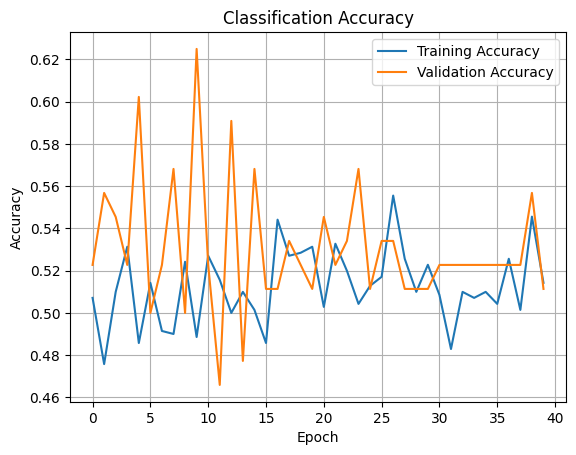

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 575ms/step - bbox_output_loss: 7094.6235 - bbox_output_mae: 70.0465 - class_output_accuracy: 0.4836 - class_output_loss: 6.0273 - loss: 7101.1240 - val_bbox_output_loss: 1301.5673 - val_bbox_output_mae: 28.2464 - val_class_output_accuracy: 0.5227 - val_class_output_loss: 1.5782 - val_loss: 1317.6969 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 690ms/step - bbox_output_loss: 1728.0670 - bbox_output_mae: 33.3229 - class_output_accuracy: 0.5007 - class_output_loss: 9.5571 - loss: 1737.6107 - val_bbox_output_loss: 908.4558 - val_bbox_output_mae: 23.3837 - val_class_output_accuracy: 0.5227 - val_class_output_loss: 2.8490 - val_loss: 916.3271 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - bbox_output_loss: 1366.9315 - bbox_output_mae: 29.5249 - class_output_accuracy: 0.5246 - class_output_loss: 9.5270 - loss: 1376.4486 - val_bbox_output_loss: 728.1080 - val_bbox_output_mae: 21.0414 - val_class_outp

KeyboardInterrupt: 

In [14]:
import train

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


We evaluate classification accuracy and bounding box MAE on the test set.

In [ ]:
results = model.evaluate(test_ds)
print(f"Classification Accuracy: {results[4]*100:.2f}%")
print(f"Bounding Box MAE: {results[2]*224:.2f} pixels")


NameError: name 'test_ds' is not defined


We plot training and validation accuracy curves across epochs.


In [ ]:
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True)   
plt.show()


NameError: name 'history' is not defined